# Dicoding Time Series Submission

Dataset used: <a href="https://www.kaggle.com/datasets/shaneysze/new-york-city-daily-temperature-18692021">New York City Daily Temperature From 1869 to 2021</a>  
By: Putu Andika Tedja Permana

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Read Data CSV

In [2]:
df = pd.read_csv('/content/nyc_temp_1869_2021.csv')
df.head()

,Unnamed: 0,MM/DD/YYYY,YEAR,MONTH,DAY,TMAX,TMIN
0,0,1869-01-01,1869,1,1,-17.0,-72.0
1,1,1869-01-02,1869,1,2,-28.0,-61.0
2,2,1869-01-03,1869,1,3,17.0,-28.0
3,3,1869-01-04,1869,1,4,28.0,11.0
4,4,1869-01-05,1869,1,5,61.0,28.0


## Data Exploratory

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55634 entries, 0 to 55633
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  55634 non-null  int64  
 1   MM/DD/YYYY  55634 non-null  object 
 2   YEAR        55634 non-null  int64  
 3   MONTH       55634 non-null  int64  
 4   DAY         55634 non-null  int64  
 5   TMAX        55634 non-null  float64
 6   TMIN        55634 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 3.0+ MB


In [4]:
# Check missing values
df.isna().sum()

Unnamed: 0    0
MM/DD/YYYY    0
YEAR          0
MONTH         0
DAY           0
TMAX          0
TMIN          0
dtype: int64

## Data Preprocessing

Divide Temperature by 10  
Based on dataset description on kaggle, the temperature is in tenths of degrees C scale, so we need to divide it with 10.

In [5]:
df['TMAX'] /= 10
df['TMIN'] /= 10

Make new columns name MEAN and set value with result of mean TMAX and TMIN

In [6]:
df['MEAN'] = df[['TMAX', 'TMIN']].astype(float).mean(axis=1)

# Convert to datetime
df['MM/DD/YYYY'] = pd.to_datetime(df['MM/DD/YYYY'])

In [7]:
# Drop unused columns
new_df = df.drop(columns=['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'TMAX', 'TMIN'])

# Rename column to date
new_df = new_df.rename(columns={'MM/DD/YYYY': 'DATE'})

In [8]:
new_df.head()

,DATE,MEAN
0,1869-01-01,-4.45
1,1869-01-02,-4.45
2,1869-01-03,-0.55
3,1869-01-04,1.95
4,1869-01-05,4.45


#### Plot Temperature Average Data

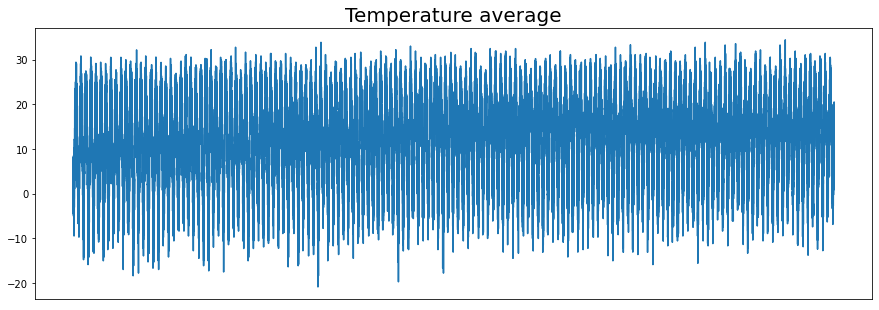

In [9]:
dates = new_df['DATE'].values
temp  = new_df['MEAN'].values

plt.figure(figsize=(15,5))
plt.xticks([], [])
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20);

#### Scale Data
Scale data with MinMaxScaler

In [10]:
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(temp.reshape(-1, 1))

#### Set Threshold MAE with 10%

In [11]:
threshold_mae = (temp_scaled.max() - temp_scaled.min()) * 10/100

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dates, temp_scaled, test_size=0.2, shuffle=False)

### Prepare Training and Testing Data

In [13]:
length = 20
train_gen = TimeseriesGenerator(y_train, y_train, length=length, batch_size=20)
test_gen = TimeseriesGenerator(y_test, y_test, length=length, batch_size=1)

## Modelling

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(16, return_sequences=True, input_shape=(length, 1)),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 16)            1152      
                                                                 
 dense (Dense)               (None, 20, 8)             136       
                                                                 
 dense_1 (Dense)             (None, 20, 1)             9         
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


#### Make Custom Callback

In [15]:
class CustomEarlyStopper(tf.keras.callbacks.Callback):
    def __init__(self, min_mae=.1):
        self.min_mae = min_mae
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < self.min_mae:
            print(f'\nMAE reached below {self.min_mae}!')
            self.model.stop_training = True

callbacks = [CustomEarlyStopper(min_mae=threshold_mae)]

#### Define Optimizer and Compile Model

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

## Training

In [17]:
history = model.fit(train_gen, epochs=100, callbacks=callbacks, validation_data=test_gen, verbose=1)

Epoch 1/100
2225/2225 [==============================] - 53s 20ms/step - loss: 0.0203 - mae: 0.1555 - val_loss: 0.0114 - val_mae: 0.1217
Epoch 2/100
2225/2225 [==============================] - 41s 18ms/step - loss: 0.0113 - mae: 0.1215 - val_loss: 0.0105 - val_mae: 0.1162
Epoch 3/100
2225/2225 [==============================] - 41s 19ms/step - loss: 0.0104 - mae: 0.1161 - val_loss: 0.0096 - val_mae: 0.1112
Epoch 4/100
2225/2225 [==============================] - 40s 18ms/step - loss: 0.0096 - mae: 0.1110 - val_loss: 0.0090 - val_mae: 0.1073
Epoch 5/100
2225/2225 [==============================] - 40s 18ms/step - loss: 0.0089 - mae: 0.1062 - val_loss: 0.0083 - val_mae: 0.1022
Epoch 6/100
2225/2225 [==============================] - 40s 18ms/step - loss: 0.0082 - mae: 0.1017 - val_loss: 0.0077 - val_mae: 0.0981
Epoch 7/100
2223/2225 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0975
MAE reached below 0.09999999999999998!
2225/2225 [==============================] - 

## Plotting

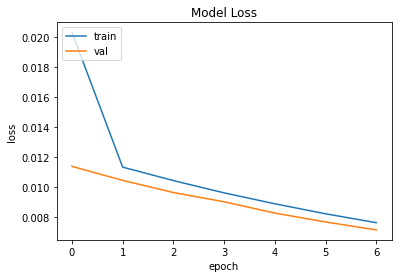

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

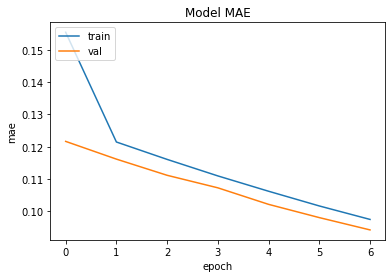

In [19]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()